In [1]:
import pandas as pd
from core.analysis import *

<Figure size 432x288 with 0 Axes>

## Data Prep

In [2]:
db = access_db()
trials = get_trial_data(db)
participants = get_participant_data(db)

In [3]:
user_data = participants[(participants['completedTask'] == 1) & (participants.index > 4) 
                         & ~(participants['workerID'].str.startswith("pilot"))] #excluding my data/Jon/Stephan
results = trials[trials['userID'].isin(user_data['userID'])]
users = user_data['userID']

## Consistency

In [18]:
repeat_corr = all_repeats(results, users, plot = False) #self correlation
shared_results = results[results['trialType'] == 'shared']
shared_corrs = group_consistency(shared_results, users) #shared correlation
user_time_word_changes = get_time_and_changes(results, user_data) #metadata
consistency = pd.DataFrame({'Group Consistency': shared_corrs, 'Self Consistency': repeat_corr})
corrs = user_time_word_changes.merge(consistency, on = user_time_word_changes.index).drop('key_0', axis = 1)
corrs['Correlation with SN'] = my_correlations(participants, trials, results, users) #vs gold standard

In [16]:
corrs.drop('userID', axis = 1).apply(np.mean)

timeTaken              692.897357
changes                  6.964286
Group Consistency        0.512886
Self Consistency         0.549777
Correlation with SN      0.509483
dtype: float64

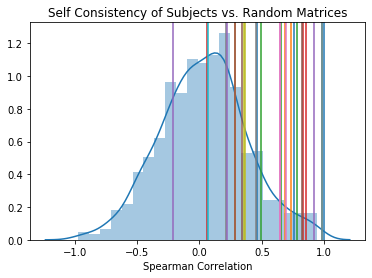

In [19]:
random_self = simulate_self_correlation(1000, db)
plot_consistency_hist(random_self, corrs['Self Consistency'], 
                      "Self Consistency of Subjects vs. Random Matrices", legend = False)

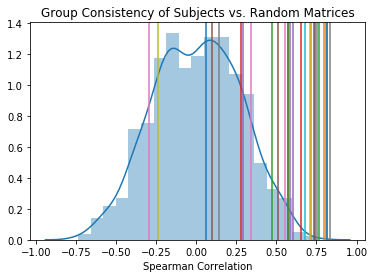

In [20]:
random_group = [random_vs_all(shared_results) for _ in range(1000)]
plot_consistency_hist(random_group, corrs['Group Consistency'], 
                      "Group Consistency of Subjects vs. Random Matrices", legend = False)

Exclusion criteria: Self below 0.2?

In [42]:
corrs[corrs['Self Consistency'] > 0.2].drop('userID', axis = 1).apply(np.mean) 
#Averages if we exclude correlation of repeat trials below 0.2 

timeTaken              718.550760
changes                  7.080000
Group Consistency        0.519520
Self Consistency         0.618878
Correlation with SN      0.533126
dtype: float64

## MDS

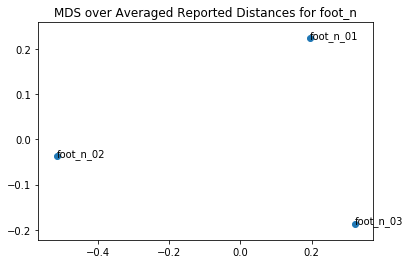

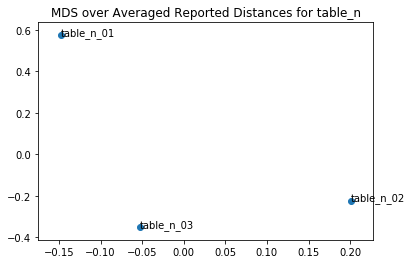

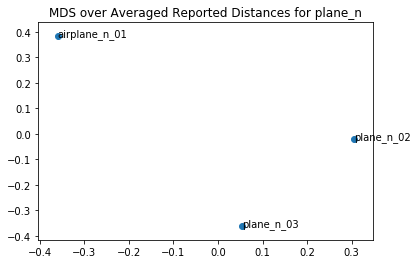

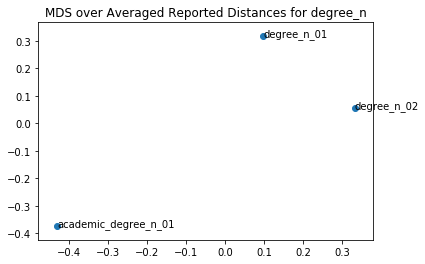

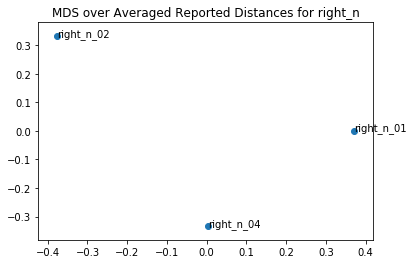

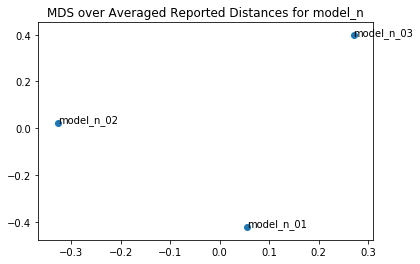

In [47]:
incl_users = corrs[corrs['Self Consistency'] > 0.2]['userID'].tolist()
plot_all_mds(results, incl_users, 'shared', db)

## Test Trials

Number of trials we got for each test/repeat word

In [59]:
test_data = results[(results['userID'].isin(incl_users)) & (results['trialType'].isin(['test', 'repeat']))]
lemma_counts = test_data['lemma'].value_counts()
lemma_counts / [get_num_senses(l, db) for l in lemma_counts.index]

world_n       15.0
case_n        15.0
indicate_v    14.0
door_n        17.0
point_n        9.0
raise_v       11.0
life_n         7.0
ask_v         14.0
drive_v       10.0
death_n        9.0
put_v         12.0
consider_v     7.0
lead_v         5.0
time_n         7.0
way_n          7.0
begin_v       11.0
glass_n       11.0
book_n        11.0
heart_n       10.0
light_n       10.0
face_n         7.0
school_n       9.0
produce_v      8.0
area_n         8.0
cover_v        4.0
man_n          2.0
Name: lemma, dtype: float64